<a href="https://colab.research.google.com/github/Alf-caput/NFL2022_TacklePredictNN/blob/dev1/no_entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NFL Big Data Bowl 2024

Kaggle lanza el concurso NFL Big Data Bowl 2024 sponsorizado por National Football League con un premio de $100,000.
https://www.kaggle.com/c/nfl-big-data-bowl-2024

## INTRODUCCIÓN

El fútbol americano es un deporte complejo donde la tarea principal de los defensores es derribar al portador del balón, mientras que este último busca avanzar en el campo. El siguiente proyecto tiene como objetivo crear métricas para valorar elementos clave en los placajes.

Se utiliza la información de las estadísticas Next Gen de la NFL, incluyendo datos de seguimiento de jugadores de las primeras nueve semanas de la temporada 2022. Estos datos abarcan la ubicación, velocidad y aceleración de los 22 jugadores en el campo, así como la posición del balón. Además, se incorporan datos de evaluación de jugadores de PFF y estadísticas avanzadas de la NFL, como puntos esperados y probabilidad de victoria.

La finalidad del proyecto es presentar los resultados a la NFL. Las métricas y análisis destacados podrían ser utilizados por los equipos de la NFL para evaluar a sus jugadores tanto en el ámbito ofensivo como defensivo.

## OBJETIVOS DEL CONCURSO

Se pide generar ideas prácticas, novedosas y ejecutables a partir de los datos de seguimiento de jugadores relacionados con los placajes. Algunos ejemplos incluyen, pero no se limitan a:

- Predicciones del tiempo, probabilidad y/o ubicación del derribo.
- Rango de derribo: ángulo de persecución, velocidad y aceleración, velocidad de cierre.
- Evaluación del jugador (por ejemplo, yardas salvadas, valor del derribo, derribos fallidos).
- Asignación de créditos (por ejemplo, un jugador realiza un derribo debido a otro jugador, bloqueos superados, área de influencia).
- Tipo de derribo (individual vs. en grupo, en campo abierto vs. en las trincheras, etc.).
- Roles y responsabilidades del equipo y los jugadores (marcar el límite, ocupar huecos, etc.).

Es importante destacar que la lista anterior no es exhaustiva y se anima a los participantes a ser creativos con sus propuestas.







# Descarga del dataset

Descargamos el dataset que ha sido previamente subido a google drive.

In [1]:
import gdown

id = '1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA'
folder = 'nfl-big-data-bowl-2024'
endpoint = '.zip'

url = f'https://drive.google.com/uc?id={id}'

output = folder + endpoint

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA
To: /content/nfl-big-data-bowl-2024.zip
100%|██████████| 293M/293M [00:02<00:00, 118MB/s]


'nfl-big-data-bowl-2024.zip'

Descomprimimos la carpeta `nfl-big-data-bowl-2024.zip` que se ha descargado.

In [2]:
from zipfile import ZipFile

with ZipFile(output, 'r') as zObject:
	zObject.extractall(folder)

Creamos una lista que contiene cada archivo `.csv` de la carpeta ya descomprimida y la ordenamos.

In [3]:
import pandas as pd
import os

csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
csv_files.sort()

Dentro de la carpeta `nfl-big-data-bowl-2024` se encuentran los csv que utilizaremos.

In [4]:
print(csv_files)

['games.csv', 'players.csv', 'plays.csv', 'tackles.csv', 'tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv', 'tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv']


A continuación creamos un diccionario para facilitarnos el acceso a los diferentes dataframes (dfs).

In [5]:
if 'dfs' not in locals(): # Si ya se ha creado, no se volverá a crear
  dfs = {os.path.splitext(file)[0]: pd.read_csv(os.path.join(folder, file)) for file in csv_files}

En el diccionario, si especificamos la clave "`games`" obtenemos el contenido del csv.

# Estudio previo de los datos

Tenemos varios dataframes que vamos a analizar para ver qué enfoque dar a los datos de entrada y de salida de la red neuronal.

Nota: Ya que la cantidad de datos en cada tabla impresa es bastante grande, usamos `.head(3)` para mostrar solamente las 3 primeras filas.

- Resultados de partidos

In [6]:
dfs['games'].head(3) # para que muestre las 3 primeras filas

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26


- Datos de seguimiento en la primera semana

In [7]:
dfs['tracking_week_1'].head(3)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN


- Datos de las jugadas realizadas

In [8]:
dfs['plays'].head(3)

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN


Queremos crear una única tabla con los ids (`gameId`) y los datos de entrenamiento de la primera semana (`tracking_week_1`)

In [9]:
game_ids = dfs['tracking_week_1']['gameId'].unique()

In [10]:
df = dfs['tracking_week_1']
df[df['gameId'] == game_ids[0]].head(3) # mostramos las 3 primeras entradas del primer partido de la primera semana de entrenamiento

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN


Vamos a obtener un snapshot del primer juego en el primer instante de tiempo y lo vamos a graficar.

In [11]:
df = dfs['tracking_week_1']
snapshot = df[df['time'] == df['time'][0]]
snapshot.head(3)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
22,2022090800,56,38577.0,Bobby Wagner,1,2022-09-08 20:24:05.200000,45.0,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN
44,2022090800,56,41239.0,Aaron Donald,1,2022-09-08 20:24:05.200000,99.0,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN


# Representación de los datos

Para graficar los jugadores en el campo en dicho instante de tiempo usaremos matplotlib.

Organizamos los distintos clubs.

In [12]:
clubs = snapshot['club'].unique()
clubs

array(['BUF', 'LA', 'football'], dtype=object)

El club 'football' es el del balón.

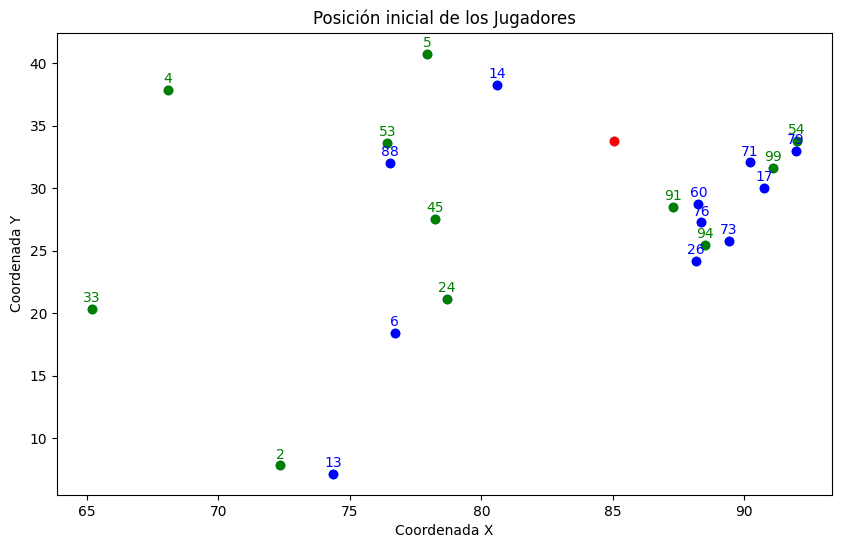

In [13]:
import matplotlib.pyplot as plt
import itertools

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(snapshot['x'], snapshot['y'], marker='o')

# Añadir etiquetas y título
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Posición inicial de los Jugadores')


# Añadir etiquetas para cada punto
for i, row in snapshot.iterrows():
    if row['club'] == clubs[0]:
      color = 'blue'
    elif row['club'] == clubs[1]:
      color = 'green'
    else:
      color = 'red'
    if color != 'red':
      plt.annotate(int(row['jerseyNumber']), (row['x'], row['y']), textcoords="offset points", xytext=(0, 5), ha='center',color=color)
    plt.scatter(row['x'], row['y'],color=color)

# Mostrar el gráfico
plt.show()

Se muestra cada equipo en un color y el balón en rojo. Cada jugador tiene un número de jersey.

Pero lo que nos interesa es ver el ritmo del juego por lo que tomaremos como ejemplo la jugada 56 del primer partido, y representaremos sus frames.

In [14]:
play56_game1 = df[df['playId']==56][df['gameId']==2022090800]

<ipython-input-14-b2f1f145e5b4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  play56_game1 = df[df['playId']==56][df['gameId']==2022090800]


Graficamos los 4 primeros frames de la jugada 56 del primer partido.

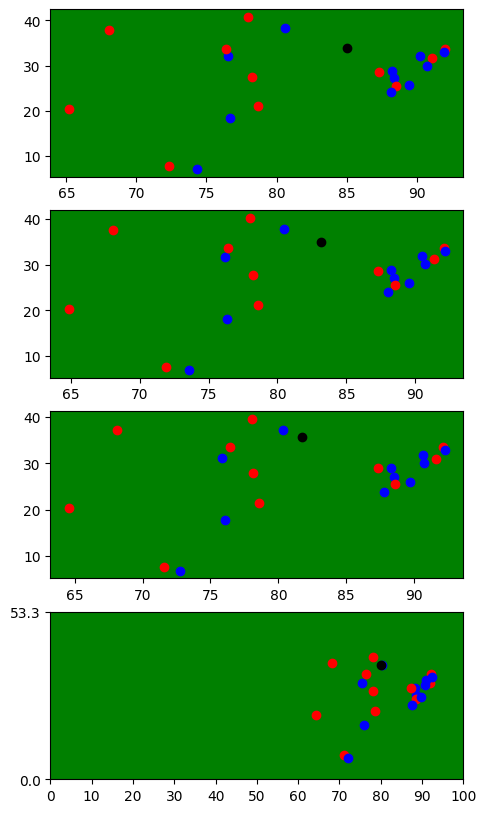

In [15]:
import matplotlib.pyplot as plt
frames = play56_game1['frameId'].unique() # contamos cuantos frames tiene la jugada 56
clubs = play56_game1['club'].unique()     # los equipos del partido (el balón es el equipo 'football')

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5.33, 10))

for frame in df['frameId'].unique()[:4]:
  snapshot = play56_game1[play56_game1['frameId'] == frame]
  for i, row in snapshot.iterrows():
    if row['club'] == clubs[0]:
      color = 'blue'
    elif row['club'] == clubs[1]:
      color = 'red'
    else:
      color = 'black'
    axs[frame-1].scatter(row['x'], row['y'], marker='o', color=color)
    plt.xticks(range(0, 110, 10))
    plt.yticks([0, 53.3])
    axs[frame-1].set_facecolor('green')

plt.show()


Podríamos graficar todos los frames pero con 4 ya se ve cómo los jugadores y el balón se mueven por el campo.

Nota: el campo de juego del fútbol americano tiene 100 yardas de largo y 53.3 de ancho.

# Preparación de los datos

La manera en la que vamos a usar los datos será en un vector, cada entrada consistirá en un frame de una jugada, y la red neuronal debe predecir quién será el portador del balón que avanzará en yardas durante la jugada.

Concatenamos todos los datos de las semanas de entrenamiento 1-10 y eliminamos algunas columnas innecesarias para la predicción. A este dataframe lo llamamos `ds`.

In [16]:
ds = pd.concat([dfs[f'tracking_week_{i}'] for i in range(1, 10)])
ds.drop(columns=['displayName', 'jerseyNumber', 'time'], inplace=True)
ds.head(3)

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,1,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,2,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,3,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN


Eliminaremos las jugadas en las que no hay uno de los 3 tipos de jugada:
- `pass_forward`
- `pass_shovel`
- `run`

Ya que los frames serían muy repetitivos de otra manera.

Así también reducimos a la mitad los frames, cosa necesaria para mantener la RAM de google collab y un tiempo asequible de compilación.

In [17]:
aux = ds[(ds['event'] == 'pass_forward') | (ds['event'] == 'pass_shovel') | (ds['event'] == 'run')]

aux_plays = aux[['gameId', 'playId']]
aux_plays.drop_duplicates(inplace=True)

ds = pd.merge(ds, aux_plays, on=['gameId', 'playId'], how='inner')

aux_frames = aux[['gameId', 'playId', 'frameId']]
aux_frames.drop_duplicates(inplace=True)
aux_frames

ds_combinado = pd.merge(ds, aux_frames, on=['gameId', 'playId'], how='left', suffixes=('', '_aux_frames'))
ds_combinado

ds = ds_combinado[ds_combinado['frameId'] <= ds_combinado['frameId_aux_frames']]

ds.drop(columns='frameId_aux_frames', inplace=True)

<ipython-input-17-12cad38779f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_plays.drop_duplicates(inplace=True)
<ipython-input-17-12cad38779f1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_frames.drop_duplicates(inplace=True)
<ipython-input-17-12cad38779f1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.drop(columns='frameId_aux_frames', inplace=True)


In [18]:
ds = ds.drop(columns=['event'])

Para asegurarnos de que hay 23 agentes en cada snapshot:

$23 = 11 jugadores\times 2 equipos + 1balón$

Los frames que no sigan esa estructura no nos aportan ninguna información y pueden suponer un problema, los queremos eliminar.

In [19]:
import numpy as np
ds_conteo = ds.groupby(['gameId', 'playId', 'frameId']).size().reset_index(name='Conteo')
print(f'Array con número de agentes por frame encontrados {np.unique(ds_conteo["Conteo"])}')

Array con número de agentes por frame encontrados [23]


Como todos siguen la estructura, no es necesario ejecutar la siguiente celda.

In [21]:
# ds = pd.merge(ds, ds_conteo, on=['gameId', 'playId', 'frameId'], how='left')
# ds = ds.loc[ds['Conteo'] != 1]
# ds_conteo = ds.groupby(['gameId', 'playId', 'frameId']).size().reset_index(name='Conteo')
# print('Limpieza de frames con nº agentes distinto a 23 (22 jugadores + 1 balón)')
# print(f'Array con número de agentes por frame encontrados {np.unique(ds_conteo["Conteo"])}')
# ds.drop(columns='Conteo', inplace=True)
# ds

## Orientación jugadores

Es NaN para el balón. Sustituimos NaN por cero.

In [20]:
ds['dir'] = ds['dir'].fillna(0)
ds['o'] = ds['o'].fillna(0)

## Yardas a completar

In [125]:
ds = pd.merge(ds, dfs['plays'][['yardsToGo', 'gameId','playId']], on=['gameId','playId'], how='left')
ds.head(1)

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir,yardsToGo
0,2022090800,80,35472.0,1,BUF,left,82.42,26.13,2.43,0.37,0.24,196.42,140.67,4


## Posición del jugador en el equipo

In [77]:
dfs['players']['position'].unique()

array(['QB', 'T', 'TE', 'WR', 'DE', 'NT', 'SS', 'FS', 'G', 'OLB', 'DT',
       'CB', 'RB', 'C', 'ILB', 'MLB', 'FB', 'LS', 'DB'], dtype=object)

Los jugadores QB, TE, WR, RB son los encargados de recibir y llevar el balón, por lo que los diferenciaremos del resto.

In [78]:
ds = pd.merge(ds, dfs['players'][['position', 'nflId']], on=['nflId'], how='left')

ds['pos_team'] = 0
ds.loc[(ds['position'] == 'QB')|(ds['position'] == 'TE')|(ds['position'] == 'WR')|(ds['position'] == 'RB'), 'pos_team'] = 1
ds.drop(columns=['position'], inplace=True)
ds.head(2)

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir,yardsToGo,pos_team
0,2022090800,80,35472.0,1,BUF,left,82.42,26.13,2.43,0.37,0.24,196.42,140.67,4,0
1,2022090800,80,35472.0,2,BUF,left,82.58,25.96,2.34,0.93,0.24,203.85,138.66,4,0


# Cuarto del partido

In [79]:
ds = pd.merge(ds, dfs['plays'][['quarter', 'gameId','playId']], on=['gameId','playId'], how='left')

## Dirección de la jugada

En vez de `left/right` usaremos 0 / 1.

In [21]:
ds['playDirection'] = ds['playDirection'].replace({'left': 0, 'right': 1})
ds.head(1)

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir
0,2022090800,80,35472.0,1,BUF,0,82.42,26.13,2.43,0.37,0.24,196.42,140.67


## Equipo local/visitante

Local/visitante aparece como `homeTeamAbbr/visitorTeamAbb`en el dataset de partidos. Y lo queremos añadir a `ds`.

In [22]:
ds = pd.merge(ds, dfs['games'][['homeTeamAbbr', 'gameId']], on='gameId', how='left')

Con valores:
- `1: local`
- `-1: visitante`
- `0: balón`

In [23]:
ds['local'] = -1
ds.loc[ds['club'] == ds['homeTeamAbbr'], 'local'] = 1
ds.loc[ds['club'] == 'football', 'local'] = 0
ds.drop(columns=['club', 'homeTeamAbbr'], inplace=True)

## Posesión del balón

Es lo que nos interesa predecir y por tanto será nuestra etiqueta en formato one-hot encoding. Es decir, un vector de 23 posiciones que toma el valor 1 en la posición del jugador que obtenga la posesión del balón.

Más adelante mostraremos la forma de la etiqueta.

In [24]:
ds = pd.merge(ds, dfs['plays'][['ballCarrierId', 'playId', 'gameId']], on=['playId', 'gameId'], how='left')
ds['ballCarrier'] = 0
ds.loc[ds['nflId'] == ds['ballCarrierId'], 'ballCarrier'] = 1
ds.drop(columns='ballCarrierId', inplace=True)

Ordenamos el dataFrame para que aparezcan primero los jugadores del equipo local seguidos por los del visitante. De esta manera, ya no necesitamos una columna que especifique de qué equipo es cada jugador. En un frame:

- Las 11 primeras filas son 11 jugadores que pertenecen al equipo local.
- Las 11 siguientes filas son 11 jugadores que pertenecen al equipo visitante.
- La última fila es el balón.

In [25]:
ds.sort_values(by=['gameId', 'playId', 'frameId', 'local'], ascending=True, inplace=True)
# Como el orden de local es ascendente los 11 jugadores de las primeras 11 filas se corresponden con visitantes
# Haciendo innecesario el uso de la columna local
ds.reset_index(drop=True, inplace=True)

In [26]:
ds.head(10)

,gameId,playId,nflId,frameId,playDirection,x,y,s,a,dis,o,dir,local,ballCarrier
0,2022090800,80,35472.0,1,0,82.42,26.13,2.43,0.37,0.24,196.42,140.67,-1,0
1,2022090800,80,42392.0,1,0,81.75,28.39,1.18,2.36,0.13,271.20,344.32,-1,0
2,2022090800,80,42489.0,1,0,69.42,22.59,5.78,5.05,0.58,298.77,287.87,-1,0
3,2022090800,80,44875.0,1,0,82.93,24.59,1.04,3.38,0.12,246.66,131.40,-1,0
4,2022090800,80,44985.0,1,0,72.64,8.50,5.55,4.09,0.57,289.54,232.62,-1,0
5,2022090800,80,46076.0,1,0,83.80,30.14,3.95,2.99,0.38,288.71,294.20,-1,1
6,2022090800,80,47857.0,1,0,84.18,45.45,4.12,1.83,0.42,222.73,340.61,-1,0
7,2022090800,80,47879.0,1,0,74.64,34.59,1.96,2.40,0.21,105.37,216.26,-1,0
8,2022090800,80,48512.0,1,0,85.59,29.63,2.46,2.27,0.26,117.12,119.97,-1,0
9,2022090800,80,52536.0,1,0,71.62,14.41,3.43,3.38,0.36,19.41,311.87,-1,0


In [27]:
ds = ds.drop(columns=['gameId','playId','nflId','frameId','local'])
ds.head(1)

,playDirection,x,y,s,a,dis,o,dir,ballCarrier
0,0,82.42,26.13,2.43,0.37,0.24,196.42,140.67,0


# Normalización de columnas

Buscamos que las columnas estén normalizadas para darle facilidad a la red neuronal.

In [28]:
columnas = ['x','y','s','a','dis','o','dir','quarter','yardsToGo']
for columna in columnas:
  # Normalización min-max
  min_val = ds[columna].min()
  max_val = ds[columna].max()
  ds[columna] = (ds[columna] - min_val) / (max_val - min_val)

In [29]:
ds.head(10)

,playDirection,x,y,s,a,dis,o,dir,ballCarrier
0,0,0.677382,0.466726,0.115166,0.014352,0.060914,0.545611,0.390750,0
1,0,0.671831,0.506940,0.055924,0.091544,0.032995,0.753333,0.956444,0
2,0,0.569677,0.403737,0.273934,0.195888,0.147208,0.829917,0.799639,0
3,0,0.681607,0.439324,0.049289,0.131109,0.030457,0.685167,0.365000,0
4,0,0.596355,0.153025,0.263033,0.158650,0.144670,0.804278,0.646167,0
5,0,0.688815,0.538078,0.187204,0.115981,0.096447,0.801972,0.817222,1
6,0,0.691964,0.810498,0.195261,0.070985,0.106599,0.618694,0.946139,0
7,0,0.612925,0.617260,0.092891,0.093095,0.053299,0.292694,0.600722,0
8,0,0.703645,0.529004,0.116588,0.088053,0.065990,0.325333,0.333250,0
9,0,0.587904,0.258185,0.162559,0.131109,0.091371,0.053917,0.866306,0


# Preparación del input

Convertimos el dataFrame a un tensor con **snapshots** y **etiquetas**.

In [31]:
import tensorflow as tf
numeric_feature_names = ['playDirection', 'x','y','s','a','dis','dir','o','quarter','yardsToGo']
numeric_features = ds[numeric_feature_names]
numeric_features.head()
snapshots = tf.convert_to_tensor(numeric_features)
snapshots = tf.reshape(snapshots, (-1, 23, 10))

target = 'ballCarrier'
label_features = ds[target]
labels = tf.convert_to_tensor(label_features)
labels = tf.reshape(labels, (-1, 23))
snapshots.shape, labels.shape

(TensorShape([12498, 23, 8]), TensorShape([12498, 23]))

Los datos de entrenamiento:

In [32]:
ds_nfl =  tf.data.Dataset.from_tensor_slices((snapshots, labels))
ds_nfl

<_TensorSliceDataset element_spec=(TensorSpec(shape=(23, 8), dtype=tf.float64, name=None), TensorSpec(shape=(23,), dtype=tf.int64, name=None))>

Imprimimos el primero para ver qué forma tiene.

In [93]:
for elem in ds_nfl.take(1):
  print(elem)

(<tf.Tensor: shape=(23, 10), dtype=float64, numpy=
array([[0.        , 0.67738194, 0.46672598, 0.11516587, 0.01435221,
        0.0609137 , 0.39075   , 0.54561111, 0.        , 0.125     ],
       [0.        , 0.67183099, 0.5069395 , 0.05592417, 0.09154383,
        0.03299492, 0.95644444, 0.75333333, 0.        , 0.125     ],
       [0.        , 0.56967688, 0.40373665, 0.27393364, 0.19588828,
        0.14720812, 0.79963889, 0.82991667, 0.        , 0.125     ],
       [0.        , 0.68160729, 0.43932384, 0.0492891 , 0.13110938,
        0.03045685, 0.365     , 0.68516667, 0.        , 0.125     ],
       [0.        , 0.5963546 , 0.15302491, 0.26303317, 0.15865011,
        0.14467005, 0.64616667, 0.80427778, 0.        , 0.125     ],
       [0.        , 0.68881524, 0.53807829, 0.18720379, 0.11598138,
        0.0964467 , 0.81722222, 0.80197222, 0.        , 0.125     ],
       [0.        , 0.69196355, 0.81049822, 0.19526066, 0.07098526,
        0.10659898, 0.94613889, 0.61869444, 0.        , 0.1

**Datos de test**

In [40]:
num_train = len(ds_nfl)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_nfl.skip(test_size)
ds_test = ds_nfl.take(test_size)

**Datos de validación**

In [41]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_nfl.skip(validation_size)
ds_val = ds_nfl.take(validation_size)

Mezclamos los datos de manera aleatoria y los empaquetamos en paquetes de tamaño 1024. Es decir, cada 1024 snapshots, se actualizan los pesos. Debido a que tenemos una gran cantidad de datos, hemos elegido un **batch_size alto** para evitar el sobreentrenamiento.

In [42]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 512
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Definición de callbacks

Utilizaremos los callbacks `ReduceLROnPlateau` y `EarlyStopping`, para disminuir el learning rate y detener el entrenamiento en caso de no mejorar la precisión en los datos de validación.

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.0001)

epoch_wait = 3
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

Como queremos obtener los mismos resultados para cualquier usuario que ejecute el programa, usamos una seed para inicializar los pesos posteriormente.

In [44]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

# Arquitectura de la red

Debido a que tenemos tensores de más de una dimensión que representan una tabla de datos, usaremos la arquitectura de una red convolucional, teniendo en cuenta las dimensiones del input.

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

# Definir la arquitectura de la red convolucional
model = models.Sequential()

model.add(layers.Input(shape=(23, 10)))

# Agregar capa de zeropadding
model.add(layers.ZeroPadding1D(padding=(2, 4)))

# Capa de convolución 1D
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))

# Capa de aplanado para conectar con una capa densa
model.add(layers.Flatten())

# Capa densa con Batch Normalization
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Capa de salida
model.add(layers.Dense(23, activation='softmax', kernel_regularizer=l2(0.01)))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen de la arquitectura del modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding1d_2 (ZeroPadd  (None, 29, 8)             0         
 ing1D)                                                          
                                                                 
 conv1d_2 (Conv1D)           (None, 27, 64)            1600      
                                                                 
 dropout_4 (Dropout)         (None, 27, 64)            0         
                                                                 
 flatten_2 (Flatten)         (None, 1728)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               221312    
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                     

## Entrenamiento del modelo

Utilizando los callbacks, datos de validación y con 50 épocas, veremos como evoluciona la precisión de la red.

Igualmente, representaremos más adelante en una gráfica el comportamiento de la red neuronal respecto a las precisiones obtenidas con los datos de test y validación.

In [48]:
history = model.fit(ds_fit, epochs=50, validation_data=ds_val, callbacks=callbacks)

Epoch 1/50
21/21 [==============================] - 3s 55ms/step - loss: 6.1534 - accuracy: 0.0727 - val_loss: 5.0588 - val_accuracy: 0.0715 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 1s 52ms/step - loss: 4.6566 - accuracy: 0.1425 - val_loss: 4.4417 - val_accuracy: 0.1531 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 1s 67ms/step - loss: 3.8298 - accuracy: 0.2159 - val_loss: 4.1240 - val_accuracy: 0.1236 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 1s 43ms/step - loss: 3.3493 - accuracy: 0.2784 - val_loss: 3.9400 - val_accuracy: 0.1261 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 1s 43ms/step - loss: 3.0807 - accuracy: 0.3339 - val_loss: 3.8987 - val_accuracy: 0.1291 - lr: 2.0000e-04
Epoch 6/50
21/21 [==============================] - 1s 43ms/step - loss: 3.0048 - accuracy: 0.3436 - val_loss: 3.8535 - val_accuracy: 0.1396 - lr: 2.0000e-04
Epoch 7/50
21/21 [==============================] - 1s 38ms/step - l

## Resultados

Con los datos de test, probaremos que precisión se consigue.

In [49]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)

20/20 [==============================] - 0s 6ms/step - loss: 2.9495 - accuracy: 0.2969
Test accuracy: 0.2969187796115875


Vamos a graficar la relación entre las precisiones de la red con datos de entrenamiento vs con datos de validación.

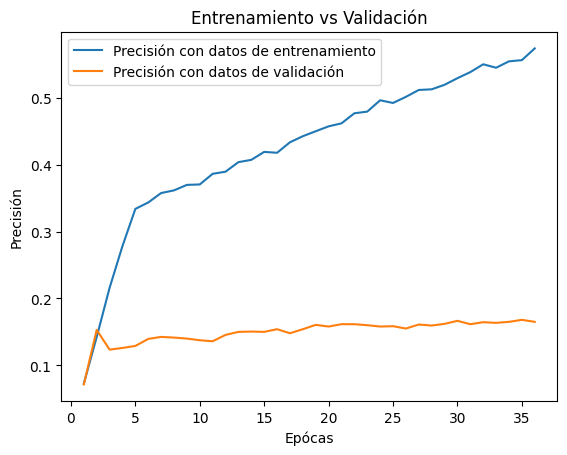

In [50]:
# Extrae la precisión de entrenamiento y validación del historial
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Número de épocas
epochs = range(1, len(train_accuracy) + 1)

# Grafica la precisión de entrenamiento y validación en función de las épocas
plt.plot(epochs, train_accuracy, label='Precisión con datos de entrenamiento')
plt.plot(epochs, val_accuracy, label='Precisión con datos de validación')
plt.title('Entrenamiento vs Validación')
plt.xlabel('Epócas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Observamos como la red siempre mejora la precisión con los datos de entrenamiento y esto acaba provocando un sobreentrenamiento, donde la precisión de datos de validación empeora ya que la red se sobreajusta a los datos de entrenamiento y pierde generalidad.

Recordamos que el objetivo era predecir, dado un frame aleatorio de una jugada, quién tendrá la posesión del balón.
